In [ ]:
# create the required directories if they don't exist
import os
import sys

# create the figures directory if it doesn't exist
if not os.path.isdir('figures'):
    os.makedirs('figures')

# create the figures/dist, figures/heat and figures/results if they don't exist
if not os.path.isdir('figures/dist'):
    os.makedirs('figures/dist')
if not os.path.isdir('figures/heat'):
    os.makedirs('figures/heat')
if not os.path.isdir('figures/results'):
    os.makedirs('figures/results')

# create the models directory if it doesn't exist
if not os.path.isdir('models'):
    os.makedirs('models')

# create the data/graphs and data/sim directories if they don't exist
# The data/csv should already exist from the git repo, it contains the data.csv file
if not os.path.isdir('data/graphs'):
    os.makedirs('data/graphs')
if not os.path.isdir('data/sim'):
    os.makedirs('data/sim')

# Cleaning data

In [ ]:
import pandas as pd
from tqdm import tqdm
import re

In [ ]:
# read the data
data = pd.read_csv('data/csv/data.csv')

In [ ]:
# seperate the data into two parts according to their VAP (0 or 1) and put them into two variables
data_0 = data[data['VAP'] == 0]
data_1 = data[data['VAP'] == 1]

# print the number of rows of the two variables
print("Class 0: ", data_0.shape[0])
print("Class 1: ", data_1.shape[0])

In [ ]:
# get the values in the TEXT column for each class
text_0 = data_0['TEXT'].values
text_1 = data_1['TEXT'].values

# make a set of all the words in the TEXT column for each class
words_0 = set()
for text in tqdm(text_0):
    for word in text.split():
        words_0.add(word)

words_1 = set()
for text in tqdm(text_1):
    for word in text.split():
        words_1.add(word)
    
# make a set of words that are in both classes
words_both = set()
for word in tqdm(words_0):
    if word in words_1:
        words_both.add(word)

In [ ]:
# print the number of unique words in each class
print("Class 0: ", len(words_0))
print("Class 1: ", len(words_1))
print("Both: ", len(words_both))

In [ ]:
threshold = 0.2
words_to_remove = set()

for word in tqdm(words_both):
    count_0 = 0
    count_1 = 0

    # count the number of times the word appears in each class
    for text in text_0:
        if word in text:
            count_0 += 1
    for text in text_1:
        if word in text:
            count_1 += 1
    
    # calculate the probability of the word appearing in each class
    prob_0 = count_0 / data_0.shape[0]
    prob_1 = count_1 / data_1.shape[0]

    # calculate the ratio of the probability of the word appearing in each class
    ratio = prob_1 / prob_0

    # if the ratio is close to 1 by a certain threshold, remove the word from the set of words that are in both classes
    if ratio >= 1 - threshold and ratio <= 1 + threshold:
        words_to_remove.add(word)

In [ ]:
# print the number of words to remove
print("Words to remove: ", len(words_to_remove))

In [ ]:
print(words_to_remove)

In [ ]:
# Compile a single regular expression that matches any word in words_to_remove
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in words_to_remove) + r')\b'
regex = re.compile(pattern)

In [ ]:
def remove_words(text):
    # Replace matched words with a single space
    text = regex.sub(' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# make a copy of the dataframe
print("Making a copy of the dataframe...")
data_cpy = data.copy()

# remove the words from the TEXT column for each row
print("Removing the words from the TEXT column for each row...")
for i in tqdm(range(data_cpy.shape[0])):
    # remove the words from the TEXT column
    text = remove_words(data_cpy.at[i, 'TEXT'])

    # if the new text is empty or contains less than 5 words, remove the row
    if len(text) == 0 or len(text.split()) < 5:
        data_cpy.drop(i, inplace=True)
        continue

    # update the TEXT column
    data_cpy.at[i, 'TEXT'] = text

# save the dataframe to a csv file
print("Saving the dataframe to a csv file...")
data_cpy.to_csv('data/csv/data_cleaned.csv', index=False)

# Embedding

In [ ]:
import pandas as pd
import numpy as np
import gensim

In [ ]:
df = pd.read_csv("data/csv/data_cleaned.csv")

In [ ]:
# creating a matrix of word embeddings using the cleaned data and the BioWordVec model
model = gensim.models.KeyedVectors.load_word2vec_format("bin/pubmed.bin", binary=True)

# function to create a matrix of word embeddings
def get_word_embeddings(sample):
    # initialize a matrix of zeros
    embeddings = np.zeros(200)
    # get the words in the sample
    words = sample.split()
    # get the number of words
    num_words = len(words)
    # loop over the words
    for word in words:
        # check if the word is in the model's vocabulary
        if word in model.key_to_index :
            # add the word embedding to the matrix
            embeddings += model[word]
    # return the matrix divided by the number of words
    return np.array(embeddings / num_words)

In [ ]:
# apply the function to the TEXT column, for each embedding, create a new column
df[["embedding_" + str(i) for i in range(200)]] = df["TEXT"].apply(get_word_embeddings).to_list()

# save the dataframe
df.to_csv("data/csv/data_embedded.csv", index=False)

# Processed data

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv("data/csv/data_embedded.csv")

In [ ]:
# seperate the features and the labels, the features are the word embeddings, each embedding is a column
X = df[[col for col in df.columns if "embedding" in col]]
y = [int(i) for i in df["VAP"].tolist()]

# initialize the SMOTE object
sm = SMOTE(random_state=42)

# fit the SMOTE object to the data
X_res, y_res = sm.fit_resample(X, y)

# create a dataframe from the augmented data
df_res = pd.DataFrame(X_res, columns=X.columns)
df_res["VAP"] = y_res

# save the dataframe
df_res.to_csv("data/csv/data_resampled.csv", index=False)

In [ ]:
# count the number of samples in each class
df_res["VAP"].value_counts()

# Similarity

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine, euclidean, chebyshev
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("data/csv/data_resampled.csv")

In [ ]:
# sim matrices
sim_dic = {
    "cos_sim":np.zeros((len(df), len(df))),
    "euc_dist":np.zeros((len(df), len(df))),
    "cheb_dist":np.zeros((len(df), len(df)))
}

# load the embeddings into a matrix
print("Loading embeddings...")
embeddings = df[[col for col in df.columns if "embedding" in col]].to_numpy()

# add edges to the graph
print("Computing similarities...")
progress = tqdm.tqdm(total=len(df))
for i in range(len(df)):
    for j in range(i+1, len(df)):

        # get the embeddings of the two nodes
        X = embeddings[i]
        Y = embeddings[j]

        # compute the similarity between the two nodes using cosine similarity and euclidean distance and chebyshev distance
        cos_sim = cosine(X, Y)
        euc_dist = euclidean(X, Y)
        cheb_dist = chebyshev(X, Y)

        # save the similarity matrices
        sim_dic["cos_sim"][i, j] = cos_sim
        sim_dic["euc_dist"][i, j] = euc_dist
        sim_dic["cheb_dist"][i, j] = cheb_dist

    # update the progress bar
    progress.update(1)

# close the progress bar
progress.close()

In [ ]:
# save the similarity matrices
np.save("data/sim/cos_sim.npy", sim_dic["cos_sim"])
np.save("data/sim/euc_dist.npy", sim_dic["euc_dist"])
np.save("data/sim/cheb_dist.npy", sim_dic["cheb_dist"])

In [ ]:
# for each similarity matrix, plot the distribution of the similarities
for sim in sim_dic.keys():

    matrix = sim_dic[sim]

    # Flatten the matrix and remove diagonal elements
    values = matrix[np.triu_indices_from(matrix, k=1)]

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(values, kde=True, bins=30)
    plt.title('Distribution of ' + sim + ' values')
    plt.xlabel('Similarity Value')
    plt.ylabel('Frequency')

    # Save the plot to a file
    plt.savefig('figures/dist/' + sim + '_distribution.png', dpi=300)
    plt.close()

In [ ]:
# for each similarity matrix, plot the heatmap of the similarities
for sim in sim_dic.keys():

    matrix = sim_dic[sim]

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix, cmap='viridis')
    plt.title('Heatmap of ' + sim + ' values')
    plt.xlabel('Node ID')
    plt.ylabel('Node ID')

    # Save the plot to a file
    plt.savefig('figures/heat/' + sim + '_heatmap.png', dpi=300)
    plt.close()

# Creating Graph

In [8]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm

In [9]:
df = pd.read_csv("data/csv/data_resampled.csv")
distance_matrix = np.load("data/sim/euc_dist.npy")

In [ ]:
# create a graph
G = nx.Graph()

# add nodes to the graph
print("Adding nodes to the graph...")
for i in tqdm(range(len(df))):
    G.add_node(i)

# make the VAP column the labels of the nodes
print("Adding labels to the nodes...")
labels = df["VAP"].to_dict()
nx.set_node_attributes(G, labels, "VAP")

In [ ]:
n = 20

# add edges to the graph
for i in tqdm(range(len(df))):

    # get top n most similar nodes
    top_n = np.argsort(distance_matrix[i])[1:n+1]

    # add edges between the node and the top n most similar nodes
    for j in top_n:
        if i != j:
            G.add_edge(i, j)

In [ ]:
# save the graph
print("Saving the graph...")
nx.write_gexf(G, "data/graphs/graph.gexf")

# Creating Graph Data

In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
import torch
from torch_geometric.utils import from_networkx

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def load_graph_data():    
    # load the graph and df
    G = nx.read_gexf("data/graphs/graph.gexf")
    df = pd.read_csv("data/csv/data_resampled.csv")

    # add features to the nodes
    print("Adding features to the nodes...")
    for node in tqdm(G.nodes(data=True)):
        node_id = int(node[0])

        node_features = df.iloc[node_id][[col for col in df.columns if "embedding" in col]].to_numpy()

        # add the node features to the graph
        node[1]["features"] = torch.tensor(node_features, dtype=torch.float)

    print("Converting the graph to a PyG data object")
    data = from_networkx(G)

    # load the data onto the device
    data = data.to(device)

    print(data)

    return data

In [4]:
data = load_graph_data()

Adding features to the nodes...


100%|██████████| 5588/5588 [00:02<00:00, 2261.60it/s]


Converting the graph to a PyG data object
Data(edge_index=[2, 223416], VAP=[5588], label=[5588], features=[5588, 200], id=[223416], mode='static', num_nodes=5588)


In [5]:
# create training and testing masks
ratio = 0.2

# get the number of nodes
num_nodes = data.num_nodes

# get the indices of the nodes
node_indices = list(range(num_nodes))

# shuffle the indices
np.random.shuffle(node_indices)

# get the number of training nodes
num_train = int(ratio * num_nodes)

# get the training indices
train_indices = node_indices[:num_train]

# get the testing indices
test_indices = node_indices[num_train:]

# create the training mask
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# create the testing mask
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_indices] = True

# load the masks onto the device
train_mask = train_mask.to(device)
test_mask = test_mask.to(device)

# Models

## GCN

In [6]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATConv
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=128, lr=0.001, weight_decay=5e-6):
        super(GCN, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(200, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)

        # initialize the loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # copy the model to the device
        self.to(device)

        # initialize the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def fit(self, data, mask, epochs, stop_acc=None):

        print("Number of training nodes: ", mask.sum())
        history = []

        progress = tqdm(total=epochs)
        for i in range(epochs):

            # put the model in training mode
            self.train()
            self.optimizer.zero_grad()

            out = self(data.features, data.edge_index)
            loss = self.criterion(out[mask], data.VAP[mask]) / mask.sum().float()

            # compute the training accuracy
            pred = out.argmax(dim=1)
            correct = pred[mask] == data.VAP[mask]
            train_acc = int(correct.sum()) / int(len(correct))

            # backpropagate the loss
            loss.backward()
            self.optimizer.step()

            # update the progress bar
            progress.set_description("Loss: {}, Train Acc: {}".format(loss, train_acc))
            progress.update(1)

            # append the loss and accuracy to the history
            history.append([loss, train_acc])

            # if the stop_acc is not None and the training accuracy is greater than or equal to the stop_acc, stop training
            if stop_acc is not None and train_acc >= stop_acc:
                print("Training accuracy reached stop_acc, stopping training...")
                break

        return history
    
    def test(self, data, mask):

        print("Number of testing nodes: ", mask.sum())
            
        # put the model in eval mode
        self.eval()

        # get the predictions
        out = self(data.features, data.edge_index)

        # compute the test accuracy
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.VAP[mask]
        test_acc = int(correct.sum()) / int(len(correct))

        return test_acc

In [11]:
# create the model
model = GCN(
    hidden_channels=128,
    lr=0.001,
    weight_decay=5e-6
)
print(model)

GCN(
  (conv1): GCNConv(200, 128)
  (conv2): GCNConv(128, 2)
  (criterion): CrossEntropyLoss()
)


In [12]:
# train the model
history_GCN = model.fit(data,
    train_mask,
    epochs=3000,
    stop_acc=None
)

Number of training nodes:  tensor(1117, device='cuda:0')


Loss: 0.00022832717513665557, Train Acc: 0.9507609668755596: 100%|██████████| 3000/3000 [00:34<00:00, 86.63it/s]


Max accuracy:  0.9767233661593554
Min loss:  0.00021681488


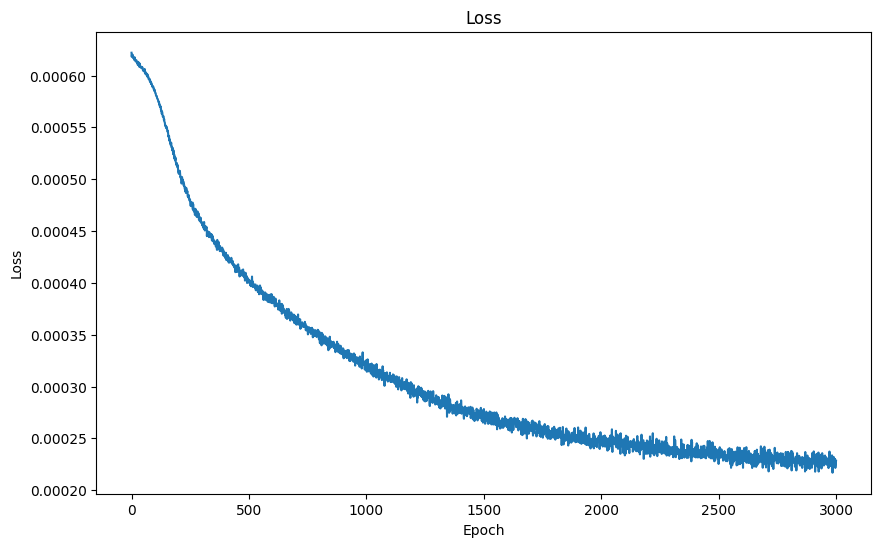

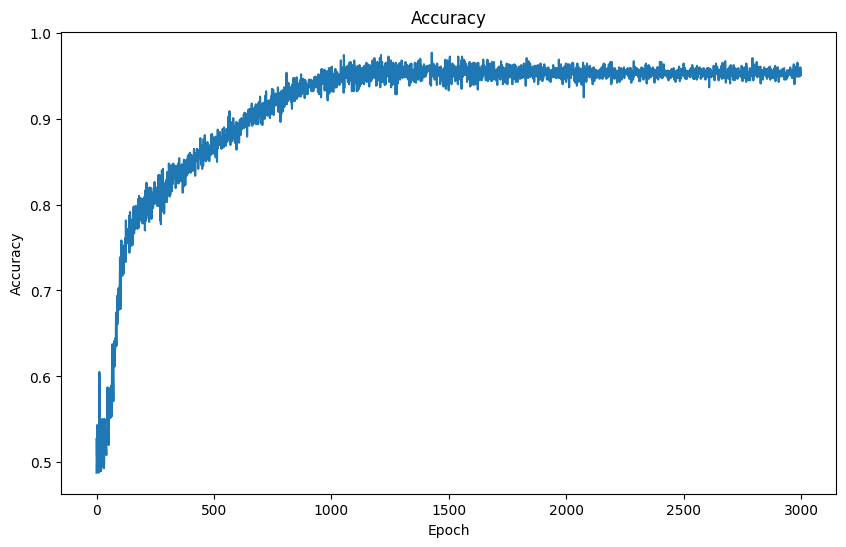

In [13]:
# get the loss and accuracy
loss = [i[0].cpu().detach().numpy() for i in history_GCN]
acc = [i[1] for i in history_GCN]

print("Max accuracy: ", max(acc))
print("Min loss: ", min(loss))

# plot and show the loss and accuracy without saving
plt.figure(figsize=(10, 6))
plt.plot(loss)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(acc)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [14]:
# test the model
test_acc_GCN = model.test(data,
                      test_mask
)
print("Test accuracy: ", test_acc_GCN)

Number of testing nodes:  tensor(4471, device='cuda:0')
Test accuracy:  0.9456497427868485


## GAT

In [15]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels=128, lr=0.001, weight_decay=5e-6):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(-1, hidden_channels, heads=8)
        self.conv2 = GATConv(hidden_channels * 8, 2, heads=1)

        # initialize the loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # copy the model to the device
        self.to(device)

        # initialize the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def fit(self, data, mask, epochs, stop_acc=None):

        # print("Number of training nodes: ", mask.sum())
        history = []

        progress = tqdm(total=epochs)
        for _ in range(epochs):

            # put the model in training mode
            self.train()
            self.optimizer.zero_grad()

            out = self(data.features, data.edge_index)
            loss = self.criterion(out[mask], data.VAP[mask]) / mask.sum().float()

            # compute the training accuracy
            pred = out.argmax(dim=1)
            correct = pred[mask] == data.VAP[mask]
            train_acc = int(correct.sum()) / int(len(correct))

            # backpropagate the loss
            loss.backward()
            self.optimizer.step()

            # append the loss and accuracy to the history
            history.append([loss, train_acc])

            # update the progress bar
            progress.set_description("Loss: {}, Train Acc: {}".format(loss, train_acc))
            progress.update(1)

            # if the stop_acc is not None and the training accuracy is greater than or equal to the stop_acc, stop training
            if stop_acc is not None and train_acc >= stop_acc:
                print("Training accuracy reached stop_acc, stopping training...")
                break

        return history

    def test(self, data, mask):

        # print("Number of testing nodes: ", mask.sum())
            
        # put the model in eval mode
        self.eval()

        # get the predictions
        out = self(data.features, data.edge_index)

        # compute the test accuracy
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.VAP[mask]
        test_acc = int(correct.sum()) / int(len(correct))

        return test_acc

In [16]:
# create the model
model_GAT = GAT(
    hidden_channels=128,
    lr=0.001,
    weight_decay=5e-6
)
print(model_GAT)

GAT(
  (conv1): GATConv(-1, 128, heads=8)
  (conv2): GATConv(1024, 2, heads=1)
  (criterion): CrossEntropyLoss()
)


In [17]:
# train the model
history_GAT = model_GAT.fit(data,
    train_mask,
    epochs=3000,
    stop_acc=None
)

Loss: 0.0003025690093636513, Train Acc: 0.8424350940017905: 100%|██████████| 3000/3000 [02:41<00:00, 18.62it/s]


Max accuracy:  0.9167412712623098
Min loss:  0.000236254


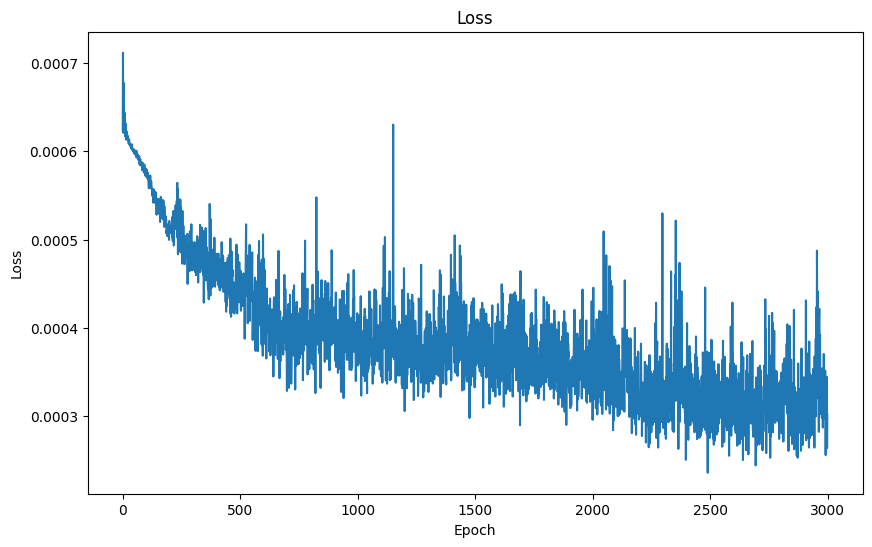

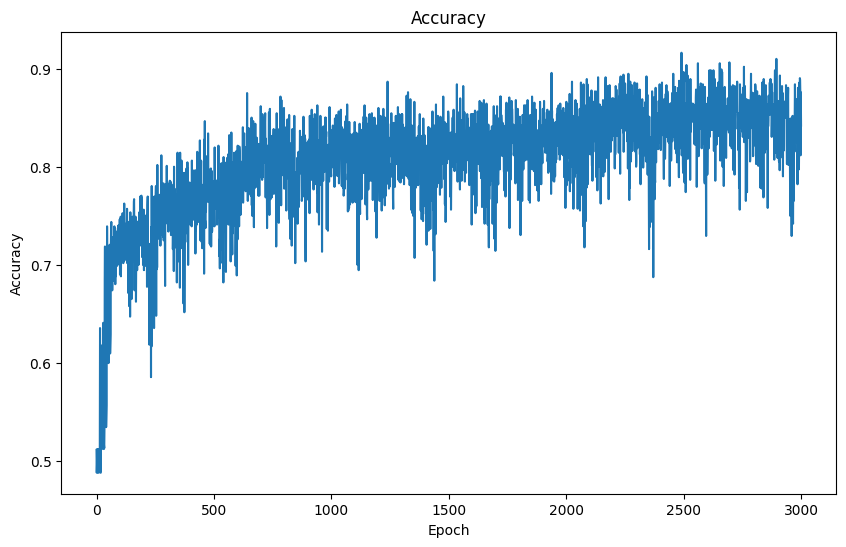

In [18]:
# get the loss and accuracy
loss = [i[0].cpu().detach().numpy() for i in history_GAT]
acc = [i[1] for i in history_GAT]

print("Max accuracy: ", max(acc))
print("Min loss: ", min(loss))

# plot and show the loss and accuracy without saving
plt.figure(figsize=(10, 6))
plt.plot(loss)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(acc)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [19]:
# test the model
test_acc_GAT = model_GAT.test(data,
                      test_mask
)
print("Test accuracy: ", test_acc_GAT)

Test accuracy:  0.7027510624021471


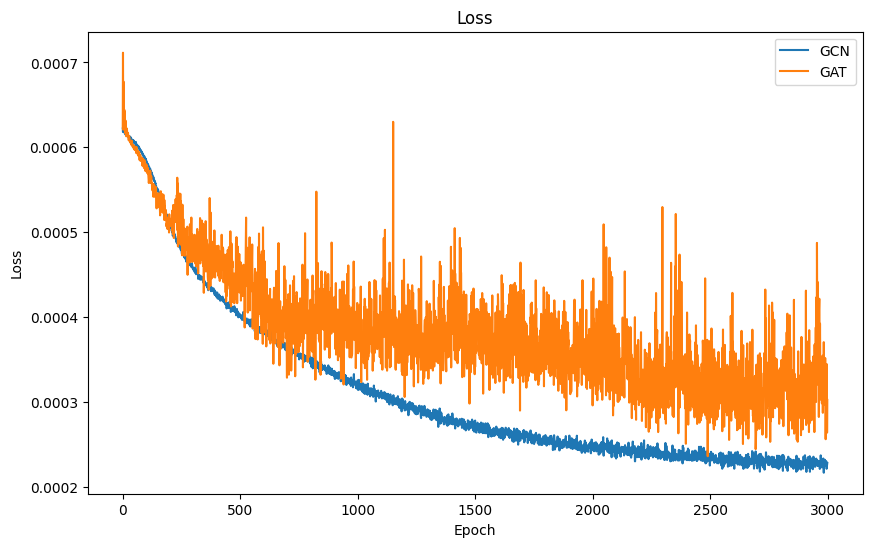

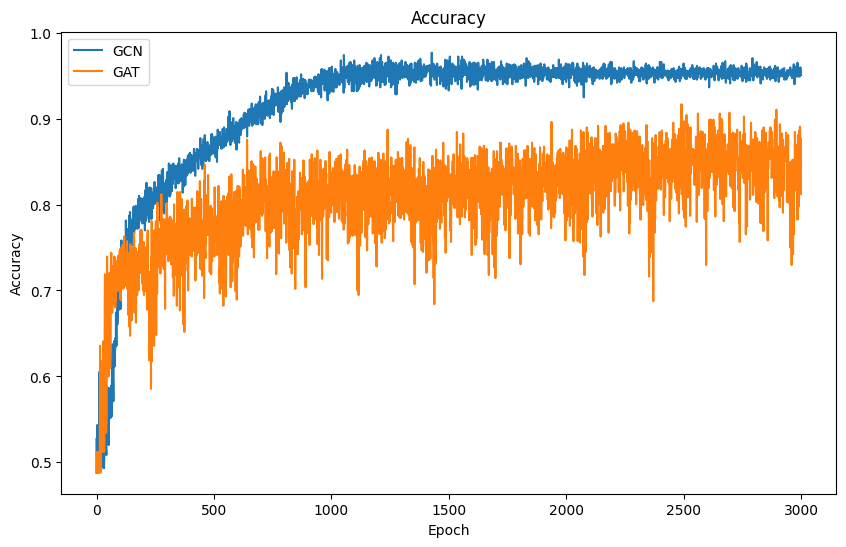

In [20]:
# plot both the evolution of the loss and accuracy for both models
# get the loss and accuracy
loss_GCN = [i[0].cpu().detach().numpy() for i in history_GCN]
acc_GCN = [i[1] for i in history_GCN]

loss_GAT = [i[0].cpu().detach().numpy() for i in history_GAT]
acc_GAT = [i[1] for i in history_GAT]

# plot and show the loss and accuracy and save the plots
plt.figure(figsize=(10, 6))
plt.plot(loss_GCN, label="GCN")
plt.plot(loss_GAT, label="GAT")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('figures/results/loss_comparison.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(acc_GCN, label="GCN")
plt.plot(acc_GAT, label="GAT")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('figures/results/acc_comparison.png', dpi=300)
plt.show()

# Finetuning Using Genetic Algorithms

In [11]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import random

In [12]:
class GCN(torch.nn.Module):
    
    def __init__(self, hidden_channels, lr, weight_decay, dropout, activation_function, optimizer):
        super(GCN, self).__init__()
        torch.manual_seed(1972)
        self.conv1 = GCNConv(200, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)
        
        # set the activation function
        if activation_function == "relu":
            self.activation_function = F.relu
        elif activation_function == "elu":
            self.activation_function = F.elu
        elif activation_function == "leaky_relu":
            self.activation_function = F.leaky_relu
        elif activation_function == "sigmoid":
            self.activation_function = torch.sigmoid
        elif activation_function == "tanh":
            self.activation_function = torch.tanh
        else:
            raise Exception("Invalid activation function")
        
        # set the dropout
        self.dropout = dropout

        # initialize the loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # keep track of the maximum accuracy and minimum loss
        self.min_loss = float("inf")
        self.max_acc = 0
        
        # copy the model to the device
        self.to(device)

        # initialize the optimizer AFTER copying the model to the device!!!!
        if optimizer == "adam":
            self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "sgd":
            self.optimizer = optim.SGD(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "rmsprop":
            self.optimizer = optim.RMSprop(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "adagrad":
            self.optimizer = optim.Adagrad(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "nadam":
            self.optimizer = optim.NAdam(self.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise Exception("Invalid optimizer")

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation_function(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def fit(self, data, mask, epochs, stop_acc=None):

        history = []

        progress = tqdm(total=epochs)
        for i in range(epochs):

            # put the model in training mode
            self.train()
            self.optimizer.zero_grad()

            out = self(data.features, data.edge_index)
            loss = self.criterion(out[mask], data.VAP[mask]) / mask.sum().float()

            # compute the training accuracy
            pred = out.argmax(dim=1)
            correct = pred[mask] == data.VAP[mask]
            train_acc = int(correct.sum()) / int(len(correct))

            # backpropagate the loss
            loss.backward()
            self.optimizer.step()

            # update the progress bar
            progress.set_description("Loss: {}, Acc: {}".format(loss, train_acc))
            progress.update(1)

            # append the loss and accuracy to the history
            history.append([loss, train_acc])

            # update the max accuracy
            if train_acc > self.max_acc:
                self.max_acc = train_acc
            
            # update the min loss
            if loss < self.min_loss:
                self.min_loss = loss

            # if the stop_acc is not None and the training accuracy is greater than or equal to the stop_acc, stop training
            if stop_acc is not None and train_acc >= stop_acc:
                print("Training accuracy reached stop_acc, stopping training...")
                break
        
        # close the progress bar
        progress.set_description(f"Min loss: {self.min_loss}, Max acc: {self.max_acc}")
        progress.close()

        return history
    
    def test(self, data, mask):

        # put the model in eval mode
        self.eval()

        # get the predictions
        out = self(data.features, data.edge_index)

        # compute the test accuracy
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.VAP[mask]
        test_acc = int(correct.sum()) / int(len(correct))

        return test_acc

In [85]:
# Tuner class for GCN hyperparameters
class GCNTuner:

    def __init__(self, population_size=50, generations=100, mutation_rate=0.1, epochs=5000):

        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate

        self.epochs = epochs

        # define the lists of hyperparameters to choose from
        self.hidden_channels = [128, 256, 512, 1024]
        self.lr = np.arange(0.00001, 0.001, 0.00005)
        self.weight_decay = np.arange(0.0000001, 0.00001, 0.0000005)
        self.dropout = np.arange(0.0001, 0.01, 0.0005)
        self.activation_function = ['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu']
        self.optimizer = ['adam', 'sgd', 'rmsprop', "adagrad"]

        # print the len of each list
        print("Running the genetic algorithm with the following hyperparameters:")
        print("Hidden channels: ", len(self.hidden_channels))
        print("Learning rates: ", len(self.lr))
        print("Weight decays: ", len(self.weight_decay))
        print("Dropouts: ", len(self.dropout))
        print("Activation functions: ", len(self.activation_function))
        print("Optimizers: ", len(self.optimizer))
        print("=====================================")

    
    def create_individual(self):
            
        # initialize the hyperparameters
        hidden_channels = np.random.choice(self.hidden_channels)
        lr = np.random.choice(self.lr)
        weight_decay = np.random.choice(self.weight_decay)
        dropout = np.random.choice(self.dropout)
        activation_function = np.random.choice(self.activation_function)
        optimizer = np.random.choice(self.optimizer)

        # create the individual
        individual = {
            "hidden_channels": hidden_channels,
            "lr": lr,
            "weight_decay": weight_decay,
            "dropout": dropout,
            "activation_function": activation_function,
            "optimizer": optimizer
        }

        return individual

    def compute_fitness(self, individual):
        # Initialize the model with the individual's hyperparameters
        model = GCN(
            hidden_channels=individual["hidden_channels"],
            lr=individual["lr"],
            weight_decay=individual["weight_decay"],
            dropout=individual["dropout"],
            activation_function=individual["activation_function"],
            optimizer=individual["optimizer"]
        )

        # Train the model and evaluate it
        model.fit(data, train_mask, self.epochs)
        
        # get the max accuracy
        return model.max_acc

    def mutate(self, individual):
        
        if np.random.random() < self.mutation_rate:
            individual["hidden_channels"] = np.random.choice(self.hidden_channels)
        if np.random.random() < self.mutation_rate:
            individual["lr"] = np.random.choice(self.lr)
        if np.random.random() < self.mutation_rate:
            individual["weight_decay"] = np.random.choice(self.weight_decay)
        if np.random.random() < self.mutation_rate:
            individual["dropout"] = np.random.choice(self.dropout)
        if np.random.random() < self.mutation_rate:
            individual["activation_function"] = np.random.choice(self.activation_function)
        if np.random.random() < self.mutation_rate:
            individual["optimizer"] = np.random.choice(self.optimizer)
        return individual

    def crossover(self, parent1, parent2):
        child = {}
        for key in parent1:
            child[key] = parent1[key] if np.random.random() > 0.5 else parent2[key]
        return child

    def optimize(self):
        print("Populating...")
        population = [self.create_individual() for _ in range(self.population_size)]

        # store the best individual and the best fitness across all generations
        best_individual = None
        best_acc = 0

        print("Evolving...")
        for generation in range(self.generations):

            print(f"Generation {generation + 1} out of {self.generations}")

            # Compute the max loss and the min accuracy for each individual in the population
            fitnesses = [self.compute_fitness(individual) for individual in population]

            # Sort the population based on fitness
            # we're using the min loss as the fitness
            sorted_population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]

            # Next generation starts with the top performers (elitism)
            next_generation = sorted_population[:2]

            # Update the best individual and the best fitness
            if fitnesses[0] > best_acc:
                best_acc = fitnesses[0]
                best_individual = population[0]

            # Fill the rest of the next generation with offspring of selected individuals
            while len(next_generation) < self.population_size:
                parents = random.sample(sorted_population[:10], 2)  # Tournament selection
                child = self.crossover(parents[0], parents[1])
                child = self.mutate(child)
                next_generation.append(child)

            population = next_generation

            # print the mean of the accuracies of the population
            print("Mean accuracy: ", np.mean(fitnesses))

        # Compute fitness for each individual in the final population
        print("Computing fitnesses for the final population...")
        fitnesses = [self.compute_fitness(individual) for individual in population]

        # update the best individual and the best fitness
        if fitnesses[0] > best_acc:
            best_acc = fitnesses[0]
            best_individual = population[0]

        # return the best individual and the best fitness
        return best_individual, best_acc
    
    def run(self):

        # run the genetic algorithm
        print("Running the genetic algorithm...")
        best_individual, best_acc = self.optimize()

        # print the best individual and the best fitness
        print("=====================================")
        print("Best model found with the following hyperparameters:")
        print("Best accuracy: ", best_acc)
        print("Best individual: ", best_individual)

        # initialize the model with the best individual's hyperparameters
        model = GCN(
            hidden_channels=best_individual["hidden_channels"],
            lr=best_individual["lr"],
            weight_decay=best_individual["weight_decay"],
            dropout=best_individual["dropout"],
            activation_function=best_individual["activation_function"],
            optimizer=best_individual["optimizer"]
        )

        # floor down the best fitness down to 4 decimal places
        best_acc = np.floor(best_acc * 10000) / 10000

        # train a new model with the best individual's hyperparameters and the stop_acc set to the best fitness
        print("Training new model with the best individual's hyperparameters...")
        hist = model.fit(data, train_mask, self.epochs, stop_acc=best_acc)

        # get the test accuracy
        test_acc = model.test(data, test_mask)

        # return the model, the best individual, the best fitness, the test accuracy and the history
        return model, best_individual, test_acc, hist

In [ ]:
# create a tuner and run it
tuner = GCNTuner(population_size=5, generations=10, mutation_rate=0.2, epochs=2000)
model, best_individual, test_acc, hist = tuner.run()

Best fitness:  1.0
Test accuracy:  0.9881458286736748
Best individual:  {'hidden_channels': 1024, 'lr': 0.00071, 'weight_decay': 6e-07, 'dropout': 0.0036, 'activation_function': 'relu', 'optimizer': 'adam'}


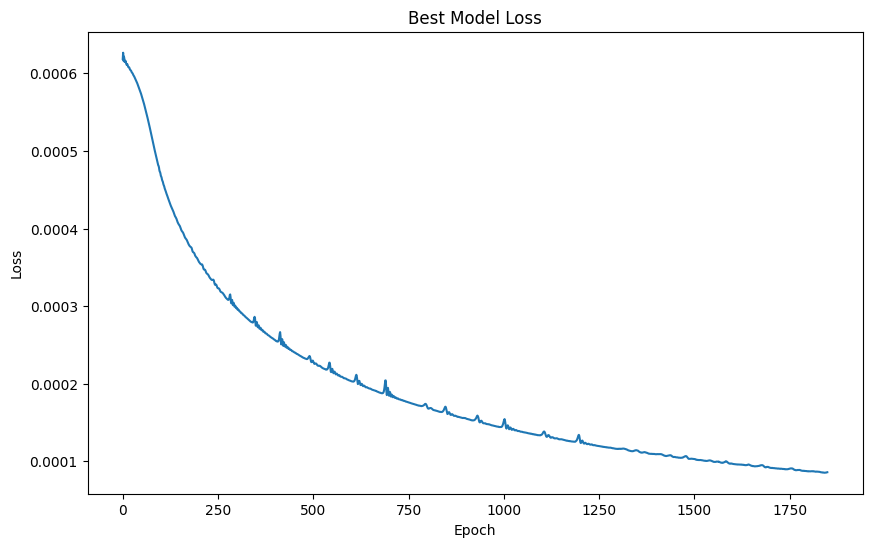

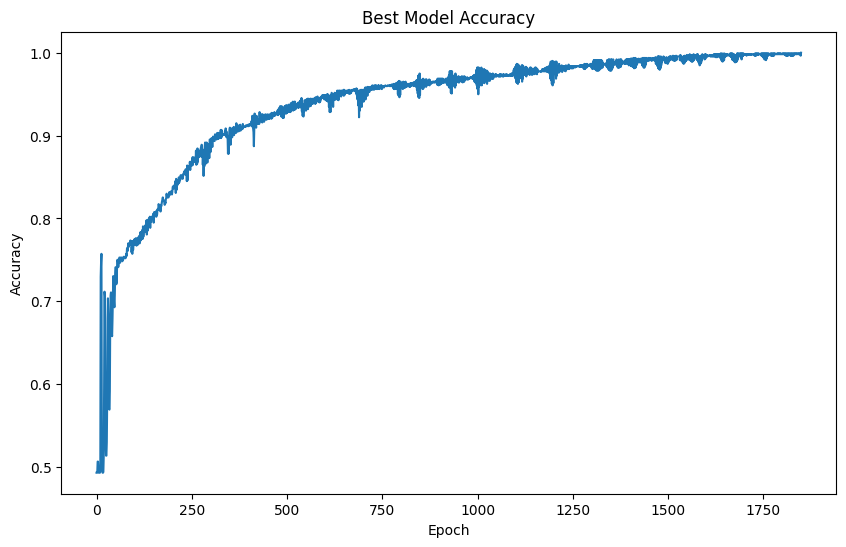

In [ ]:
# print and plot the results
print("Results for the best model:")
print("Training loss: ", model.min_loss)
print("Training accuracy: ", model.max_acc)
print("Testing accuracy: ", test_acc)
print("Parameters: ", best_individual)

# get the loss and accuracy
loss = [i[0].cpu().detach().numpy() for i in hist]
acc = [i[1] for i in hist]

# plot and show the loss and accuracy and save them
plt.figure(figsize=(10, 6))
plt.plot(loss)
plt.title("Best Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('figures/results/best_loss.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(acc)
plt.title("Best Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig('figures/results/best_acc.png', dpi=300)
plt.show()

# save the model
torch.save(model.state_dict(), "models/best_model.pt")

# save the best individual as a pickle file
with open("models/best_individual.pkl", "wb") as f:
    pickle.dump(best_individual, f)

# Model Validation

In [5]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.model_selection import KFold

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class GCN(torch.nn.Module):
    
    def __init__(self, hidden_channels, lr, weight_decay, dropout, activation_function, optimizer):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(200, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)
        
        # set the activation function
        if activation_function == "relu":
            self.activation_function = F.relu
        elif activation_function == "elu":
            self.activation_function = F.elu
        elif activation_function == "leaky_relu":
            self.activation_function = F.leaky_relu
        elif activation_function == "sigmoid":
            self.activation_function = torch.sigmoid
        elif activation_function == "tanh":
            self.activation_function = torch.tanh
        else:
            raise Exception("Invalid activation function")
        
        # set the dropout
        self.dropout = dropout

        # initialize the loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # keep track of the maximum accuracy and minimum loss
        self.min_loss = float("inf")
        self.max_acc = 0
        
        # copy the model to the device
        self.to(device)

        # initialize the optimizer AFTER copying the model to the device!!!!
        if optimizer == "adam":
            self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "sgd":
            self.optimizer = optim.SGD(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "rmsprop":
            self.optimizer = optim.RMSprop(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "adagrad":
            self.optimizer = optim.Adagrad(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "nadam":
            self.optimizer = optim.NAdam(self.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise Exception("Invalid optimizer")

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation_function(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def fit(self, data, mask, epochs, stop_acc=None):

        history = []

        progress = tqdm(total=epochs)
        for i in range(epochs):

            # put the model in training mode
            self.train()
            self.optimizer.zero_grad()

            out = self(data.features, data.edge_index)
            loss = self.criterion(out[mask], data.VAP[mask]) / mask.sum().float()

            # compute the training accuracy
            train_acc = self.test(data, mask)

            # backpropagate the loss
            loss.backward()
            self.optimizer.step()

            # update the progress bar
            progress.set_description("Loss: {}, Acc: {}".format(loss, train_acc))
            progress.update(1)

            # append the loss and accuracy to the history
            history.append([loss, train_acc])

            # update the max accuracy
            if train_acc > self.max_acc:
                self.max_acc = train_acc
            
            # update the min loss
            if loss < self.min_loss:
                self.min_loss = loss

            # if the stop_acc is not None and the training accuracy is greater than or equal to the stop_acc, stop training
            if stop_acc is not None and train_acc >= stop_acc:
                print("Training accuracy reached stop_acc, stopping training...")
                break
        
        # close the progress bar
        progress.set_description(f"Min loss: {self.min_loss}, Max acc: {self.max_acc}")
        progress.close()

        return history
    
    def test(self, data, mask):

        # put the model in eval mode
        self.eval()

        # get the predictions
        out = self(data.features, data.edge_index)

        # compute the test accuracy
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.VAP[mask]
        test_acc = int(correct.sum()) / int(len(correct))

        return test_acc

In [8]:
# load the best individual from the pickle file
with open("models/best_individual.pkl", "rb") as f:
    best_individual = pickle.load(f)

In [9]:
# load data
data = load_graph_data()

Adding features to the nodes...


100%|██████████| 5588/5588 [00:02<00:00, 2540.59it/s]


Converting the graph to a PyG data object
Data(edge_index=[2, 223416], VAP=[5588], label=[5588], features=[5588, 200], id=[223416], mode='static', num_nodes=5588)


In [10]:
# Define different train percentages
train_percentages_masks = {
    5:{
        "train_masks":[],
        "test_masks":[]
    },
    10:{
        "train_masks":[],
        "test_masks":[]
    },
    15:{
        "train_masks":[],
        "test_masks":[]
    },
    20:{
        "train_masks":[],
        "test_masks":[]
    }
}

# Get the number of nodes
num_nodes = data.num_nodes

# For each train percentage, perform inverse k-fold cross-validation
for train_percentage in train_percentages_masks.keys():
    # Calculate the number of folds (inverse logic)
    k = 100 // train_percentage

    # Create KFold object
    kf = KFold(n_splits=k, shuffle=True)

    # Initialize masks for each fold
    train_masks = []
    test_masks = []

    # Iterate over each fold
    for train_index, test_index in kf.split(range(num_nodes)):

        # Create training and testing masks (inverse logic)
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        # In this case, train_index is used for testing and test_index for training
        train_mask[test_index] = True
        test_mask[train_index] = True
        
        # Load the masks onto the device
        train_mask = train_mask.to(device)
        test_mask = test_mask.to(device)

        # Store the masks
        train_masks.append(train_mask)
        test_masks.append(test_mask)
    
    # Store the masks for the current train percentage
    train_percentages_masks[train_percentage]["train_masks"] = train_masks
    train_percentages_masks[train_percentage]["test_masks"] = test_masks

In [11]:
# for every train percentage, perform inverse k-fold cross-validation
# get the mean, the std and the min and max accuracies
# save the results to a csv file

with open("inv_k_fold.csv", "w") as f:
    f.write("train_percentage,mean,std,min,max\n")

for train_percentage in train_percentages_masks.keys():

    print(f"{train_percentage}% of data used for training")

    # get the train masks
    train_masks = train_percentages_masks[train_percentage]["train_masks"]

    # get the test masks
    test_masks = train_percentages_masks[train_percentage]["test_masks"]

    # get the accuracies for each fold
    accuracies = []

    # for each fold
    for i in range(len(train_masks)):

        print(f"Fold {i+1} out of {len(train_masks)}")

        # get the train mask
        train_mask = train_masks[i]

        # get the test mask
        test_mask = test_masks[i]

        # create the model
        model = GCN(
            hidden_channels=best_individual["hidden_channels"],
            lr=best_individual["lr"],
            weight_decay=best_individual["weight_decay"],
            dropout=best_individual["dropout"],
            activation_function=best_individual["activation_function"],
            optimizer=best_individual["optimizer"]
        )

        # train the model
        model.fit(data, train_mask, epochs=2000)

        # get the test accuracy
        test_acc = model.test(data, test_mask)

        # append the test accuracy to the list
        accuracies.append(test_acc)

    # get the mean of the accuracies
    mean = np.mean(accuracies)

    # get the std of the accuracies
    std = np.std(accuracies)

    # get the min and max accuracies
    min_acc = min(accuracies)
    max_acc = max(accuracies)

    # print the results
    print(f"Train percentage: {train_percentage}, Mean: {mean}, Std: {std}, Min: {min_acc}, Max: {max_acc}")

    # save the results to a csv file
    with open("inv_k_fold.csv", "a") as f:
        f.write(f"{train_percentage},{mean},{std},{min_acc},{max_acc}\n")

5% of data used for training
Fold 1 out of 20


Min loss: 0.00019999327196273953, Max acc: 0.9964285714285714: 100%|██████████| 2000/2000 [01:46<00:00, 18.86it/s]


Fold 2 out of 20


Min loss: 0.00023424085520673543, Max acc: 0.9964285714285714: 100%|██████████| 2000/2000 [01:45<00:00, 18.89it/s]


Fold 3 out of 20


Min loss: 0.000284714245935902, Max acc: 0.9928571428571429: 100%|██████████| 2000/2000 [01:46<00:00, 18.85it/s]


Fold 4 out of 20


Min loss: 0.0002453332708682865, Max acc: 1.0: 100%|██████████| 2000/2000 [01:46<00:00, 18.79it/s]        


Fold 5 out of 20


Min loss: 0.0002267001400468871, Max acc: 1.0: 100%|██████████| 2000/2000 [01:46<00:00, 18.78it/s]        


Fold 6 out of 20


Min loss: 0.00031389345531351864, Max acc: 0.9857142857142858: 100%|██████████| 2000/2000 [01:46<00:00, 18.76it/s]


Fold 7 out of 20


Min loss: 0.0002586283953860402, Max acc: 1.0: 100%|██████████| 2000/2000 [01:46<00:00, 18.70it/s]        


Fold 8 out of 20


Min loss: 0.00024855334777384996, Max acc: 0.9964285714285714: 100%|██████████| 2000/2000 [01:46<00:00, 18.76it/s]


Fold 9 out of 20


Min loss: 0.00023179914569482207, Max acc: 1.0: 100%|██████████| 2000/2000 [01:46<00:00, 18.72it/s]       


Fold 10 out of 20


Min loss: 0.0002129844797309488, Max acc: 0.996415770609319: 100%|██████████| 2000/2000 [01:47<00:00, 18.69it/s]


Fold 11 out of 20


Min loss: 0.0001824908540584147, Max acc: 1.0: 100%|██████████| 2000/2000 [01:47<00:00, 18.62it/s]       


Fold 12 out of 20


Min loss: 0.00025646842550486326, Max acc: 0.996415770609319: 100%|██████████| 2000/2000 [01:47<00:00, 18.66it/s]


Fold 13 out of 20


Min loss: 0.00021327685681171715, Max acc: 0.996415770609319: 100%|██████████| 2000/2000 [01:47<00:00, 18.62it/s]


Fold 14 out of 20


Min loss: 0.0002625388733576983, Max acc: 0.996415770609319: 100%|██████████| 2000/2000 [01:47<00:00, 18.66it/s]


Fold 15 out of 20


Min loss: 0.0002686839725356549, Max acc: 0.992831541218638: 100%|██████████| 2000/2000 [01:46<00:00, 18.77it/s]


Fold 16 out of 20


Min loss: 0.000272734381724149, Max acc: 0.996415770609319: 100%|██████████| 2000/2000 [01:46<00:00, 18.73it/s]


Fold 17 out of 20


Min loss: 0.0001820861507439986, Max acc: 1.0: 100%|██████████| 2000/2000 [01:47<00:00, 18.66it/s]        


Fold 18 out of 20


Min loss: 0.00020627453341148794, Max acc: 1.0: 100%|██████████| 2000/2000 [01:46<00:00, 18.73it/s]       


Fold 19 out of 20


Min loss: 0.00019434303976595402, Max acc: 1.0: 100%|██████████| 2000/2000 [01:46<00:00, 18.69it/s]       


Fold 20 out of 20


Min loss: 0.00019558648637030274, Max acc: 1.0: 100%|██████████| 2000/2000 [01:46<00:00, 18.72it/s]       


Train percentage: 5, Mean: 0.9479520848914621, Std: 0.019917558277694637, Min: 0.9133546807308345, Max: 0.9834243737050292
10% of data used for training
Fold 1 out of 10


Min loss: 0.00019690810586325824, Max acc: 0.9928443649373881: 100%|██████████| 2000/2000 [01:47<00:00, 18.53it/s]


Fold 2 out of 10


Min loss: 0.00010894989827647805, Max acc: 1.0: 100%|██████████| 2000/2000 [01:46<00:00, 18.71it/s]       


Fold 3 out of 10


Min loss: 0.00014025752898305655, Max acc: 0.9964221824686941: 100%|██████████| 2000/2000 [01:46<00:00, 18.71it/s]


Fold 4 out of 10


Min loss: 0.00015781412366777658, Max acc: 0.9964221824686941: 100%|██████████| 2000/2000 [01:46<00:00, 18.71it/s]


Fold 5 out of 10


Min loss: 0.00015307629655580968, Max acc: 0.9946332737030411: 100%|██████████| 2000/2000 [01:46<00:00, 18.73it/s]


Fold 6 out of 10


Min loss: 0.00015814694052096456, Max acc: 0.9964221824686941: 100%|██████████| 2000/2000 [01:47<00:00, 18.68it/s]


Fold 7 out of 10


Min loss: 0.00018734598415903747, Max acc: 0.9910554561717353: 100%|██████████| 2000/2000 [01:47<00:00, 18.67it/s]


Fold 8 out of 10


Min loss: 0.00013526160910259932, Max acc: 0.998211091234347: 100%|██████████| 2000/2000 [01:46<00:00, 18.70it/s]


Fold 9 out of 10


Min loss: 0.0001583972480148077, Max acc: 0.992831541218638: 100%|██████████| 2000/2000 [01:46<00:00, 18.70it/s]


Fold 10 out of 10


Min loss: 0.00015581953630317003, Max acc: 0.9982078853046595: 100%|██████████| 2000/2000 [01:46<00:00, 18.77it/s]


Train percentage: 10, Mean: 0.9786847497239668, Std: 0.01087515574819738, Min: 0.9606361829025845, Max: 0.9980115331079737
15% of data used for training
Fold 1 out of 6


Min loss: 8.830855949781835e-05, Max acc: 1.0: 100%|██████████| 2000/2000 [01:47<00:00, 18.64it/s]        


Fold 2 out of 6


Min loss: 0.00010118782665813342, Max acc: 1.0: 100%|██████████| 2000/2000 [01:46<00:00, 18.73it/s]       


Fold 3 out of 6


Min loss: 0.00011006127169821411, Max acc: 0.9967776584317938: 100%|██████████| 2000/2000 [01:46<00:00, 18.72it/s]


Fold 4 out of 6


Min loss: 0.00010387997463112697, Max acc: 0.9978517722878625: 100%|██████████| 2000/2000 [01:47<00:00, 18.64it/s]


Fold 5 out of 6


Min loss: 0.00010970552102662623, Max acc: 0.9978517722878625: 100%|██████████| 2000/2000 [01:47<00:00, 18.67it/s]


Fold 6 out of 6


Min loss: 0.00010722426668507978, Max acc: 1.0: 100%|██████████| 2000/2000 [01:47<00:00, 18.62it/s]       


Train percentage: 15, Mean: 0.9916966486912876, Std: 0.0034012341599804676, Min: 0.9875456302340563, Max: 0.9976374570446735
20% of data used for training
Fold 1 out of 5


Min loss: 8.238581358455122e-05, Max acc: 0.9991055456171736: 100%|██████████| 2000/2000 [01:47<00:00, 18.65it/s]


Fold 2 out of 5


Min loss: 8.797289046924561e-05, Max acc: 1.0: 100%|██████████| 2000/2000 [01:47<00:00, 18.68it/s]        


Fold 3 out of 5


Min loss: 7.586343417642638e-05, Max acc: 1.0: 100%|██████████| 2000/2000 [01:47<00:00, 18.63it/s]        


Fold 4 out of 5


Min loss: 8.045986760407686e-05, Max acc: 0.9973142345568488: 100%|██████████| 2000/2000 [01:47<00:00, 18.66it/s]


Fold 5 out of 5


Min loss: 7.956662739161402e-05, Max acc: 1.0: 100%|██████████| 2000/2000 [01:47<00:00, 18.63it/s]        


Train percentage: 20, Mean: 0.9957946537892468, Std: 0.002160981619312106, Min: 0.9917244464325654, Max: 0.9977633639006933


# Plots

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# read the results from the csv file
df = pd.read_csv("inv_k_fold.csv")

# multiply percentages by 100
df["mean"] = df["mean"] * 100
df["max"] = df["max"] * 100
df["min"] = df["min"] * 100 

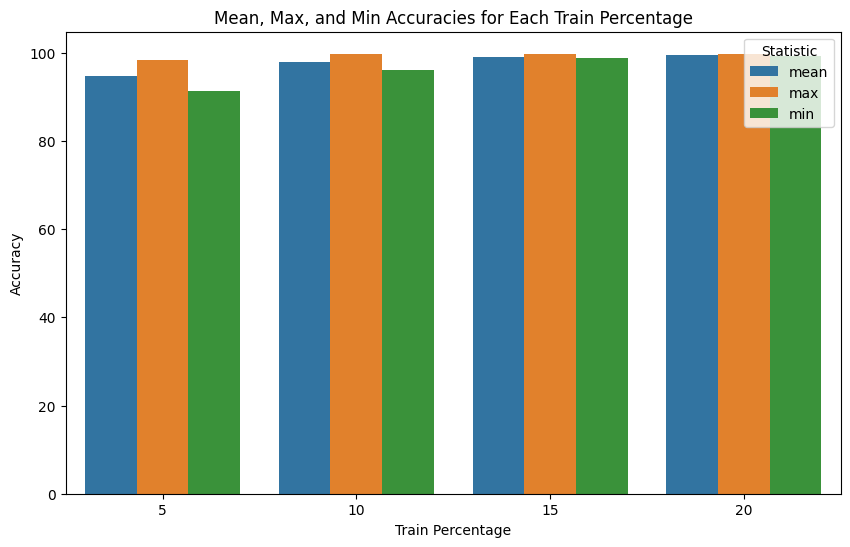

In [9]:
# Example of reshaping your data
df_long = pd.melt(df, id_vars='train_percentage', value_vars=['mean', 'max', 'min'],
                  var_name='statistic_type', value_name='accuracy')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="train_percentage", y="accuracy", hue="statistic_type", data=df_long)
plt.legend(title="Statistic")
plt.title("Mean, Max, and Min Accuracies for Each Train Percentage")
plt.xlabel("Train Percentage")
plt.ylabel("Accuracy")
plt.savefig('figures/results/inv_k_fold.png', dpi=300)

# Metrics

In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.manifold import TSNE


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class GCN(torch.nn.Module):
    
    def __init__(self, hidden_channels, lr, weight_decay, dropout, activation_function, optimizer):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(200, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)
        
        # set the activation function
        if activation_function == "relu":
            self.activation_function = F.relu
        elif activation_function == "elu":
            self.activation_function = F.elu
        elif activation_function == "leaky_relu":
            self.activation_function = F.leaky_relu
        elif activation_function == "sigmoid":
            self.activation_function = torch.sigmoid
        elif activation_function == "tanh":
            self.activation_function = torch.tanh
        else:
            raise Exception("Invalid activation function")
        
        # set the dropout
        self.dropout = dropout

        # initialize the loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # keep track of the maximum accuracy and minimum loss
        self.min_loss = float("inf")
        self.max_acc = 0
        
        # copy the model to the device
        self.to(device)

        # initialize the optimizer AFTER copying the model to the device!!!!
        if optimizer == "adam":
            self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "sgd":
            self.optimizer = optim.SGD(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "rmsprop":
            self.optimizer = optim.RMSprop(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "adagrad":
            self.optimizer = optim.Adagrad(self.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer == "nadam":
            self.optimizer = optim.NAdam(self.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise Exception("Invalid optimizer")

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation_function(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def fit(self, data, mask, epochs, stop_acc=None):

        history = []

        progress = tqdm(total=epochs)
        for i in range(epochs):

            # put the model in training mode
            self.train()
            self.optimizer.zero_grad()

            out = self(data.features, data.edge_index)
            loss = self.criterion(out[mask], data.VAP[mask]) / mask.sum().float()

            # compute the training accuracy
            train_acc = self.get_accuracy(data, mask)

            # backpropagate the loss
            loss.backward()
            self.optimizer.step()

            # update the progress bar
            progress.set_description("Loss: {}, Acc: {}".format(loss, train_acc))
            progress.update(1)

            # append the loss and accuracy to the history
            history.append([loss, train_acc])

            # update the max accuracy
            if train_acc > self.max_acc:
                self.max_acc = train_acc
            
            # update the min loss
            if loss < self.min_loss:
                self.min_loss = loss

            # if the stop_acc is not None and the training accuracy is greater than or equal to the stop_acc, stop training
            if stop_acc is not None and train_acc >= stop_acc:
                print("Training accuracy reached stop_acc, stopping training...")
                break
        
        # close the progress bar
        progress.set_description(f"Min loss: {self.min_loss}, Max acc: {self.max_acc}")
        progress.close()

        return history
    
    def get_accuracy(self, data, mask):
            
        # put the model in eval mode
        self.eval()

        # get the predictions
        out = self(data.features, data.edge_index)

        # compute the test accuracy
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.VAP[mask]
        test_acc = int(correct.sum()) / int(len(correct))

        return test_acc
    
    def test(self, data, mask):

        # put the model in eval mode
        self.eval()

        # get the predictions
        out = self(data.features, data.edge_index)

        # compute the test accuracy
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.VAP[mask]
        test_acc = int(correct.sum()) / int(len(correct))

        # compute the f1 score
        f1 = f1_score(data.VAP[mask].cpu().numpy(), pred[mask].cpu().numpy())

        # compute the precision
        precision = precision_score(data.VAP[mask].cpu().numpy(), pred[mask].cpu().numpy())

        # compute the recall
        recall = recall_score(data.VAP[mask].cpu().numpy(), pred[mask].cpu().numpy())

        # get the confusion matrix
        cm = confusion_matrix(data.VAP[mask].cpu().numpy(), pred[mask].cpu().numpy())

        return test_acc, f1, precision, recall, cm

In [4]:
# load the best individual from the pickle file
with open("models/best_individual.pkl", "rb") as f:
    best_individual = pickle.load(f)

# create the model
model = GCN(
    hidden_channels=best_individual["hidden_channels"],
    lr=best_individual["lr"],
    weight_decay=best_individual["weight_decay"],
    dropout=best_individual["dropout"],
    activation_function=best_individual["activation_function"],
    optimizer=best_individual["optimizer"]
)

In [12]:
# load data
data = load_graph_data()

Adding features to the nodes...


100%|██████████| 5588/5588 [00:02<00:00, 2336.44it/s]


Converting the graph to a PyG data object
Data(edge_index=[2, 223416], VAP=[5588], label=[5588], features=[5588, 200], id=[223416], mode='static', num_nodes=5588)


In [13]:
# create training and testing masks
ratio = 0.2

# get the number of nodes
num_nodes = data.num_nodes

# get the indices of the nodes
node_indices = list(range(num_nodes))

# shuffle the indices
np.random.shuffle(node_indices)

# get the number of training nodes
num_train = int(ratio * num_nodes)

# get the training indices
train_indices = node_indices[:num_train]

# get the testing indices
test_indices = node_indices[num_train:]

# create the training mask
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# create the testing mask
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_indices] = True

# load the masks onto the device
train_mask = train_mask.to(device)
test_mask = test_mask.to(device)

In [14]:
# fit the model
model.fit(data, train_mask, epochs=2000, stop_acc=0.998)

Min loss: 0.00010088570707011968, Max acc: 0.9973142345568488: 100%|██████████| 2000/2000 [01:52<00:00, 17.73it/s]


[[tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>),
  0.37600716204118173],
 [tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>), 0.4834377797672337],
 [tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>), 0.4834377797672337],
 [tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>), 0.5165622202327663],
 [tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>), 0.5165622202327663],
 [tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>), 0.5165622202327663],
 [tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>), 0.4834377797672337],
 [tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>), 0.4834377797672337],
 [tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>), 0.4834377797672337],
 [tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>), 0.4834377797672337],
 [tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>), 0.4834377797672337],
 [tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>), 0.4968666069829902],
 [tensor(0.0006, device='cuda:0', gra

In [17]:
# test the model
test_acc, f1, precision, recall, cm = model.test(data, test_mask)

Test accuracy:  0.9774099753970029
F1 score:  0.9776301218161684
Precision:  0.9604003481288077
Recall:  0.995489400090212
Confusion matrix: 


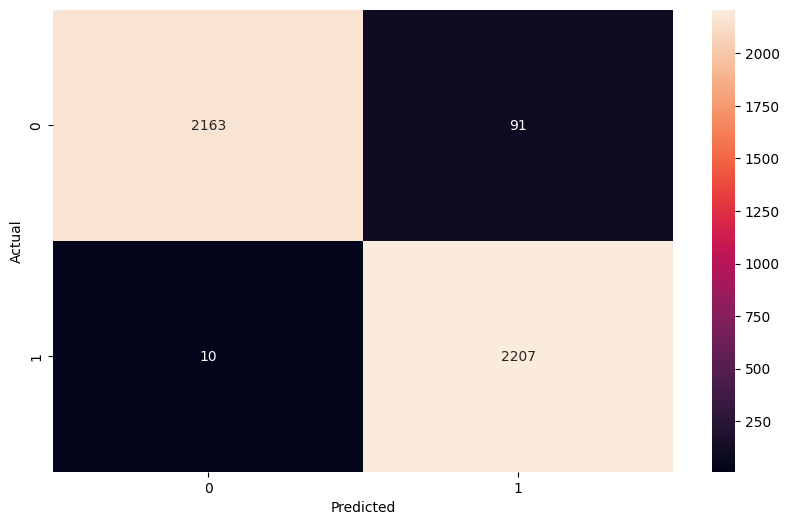

In [18]:
# print the results
print("Test accuracy: ", test_acc)
print("F1 score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Confusion matrix: ")

# plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('figures/results/confusion_matrix.png', dpi=300)
plt.show()

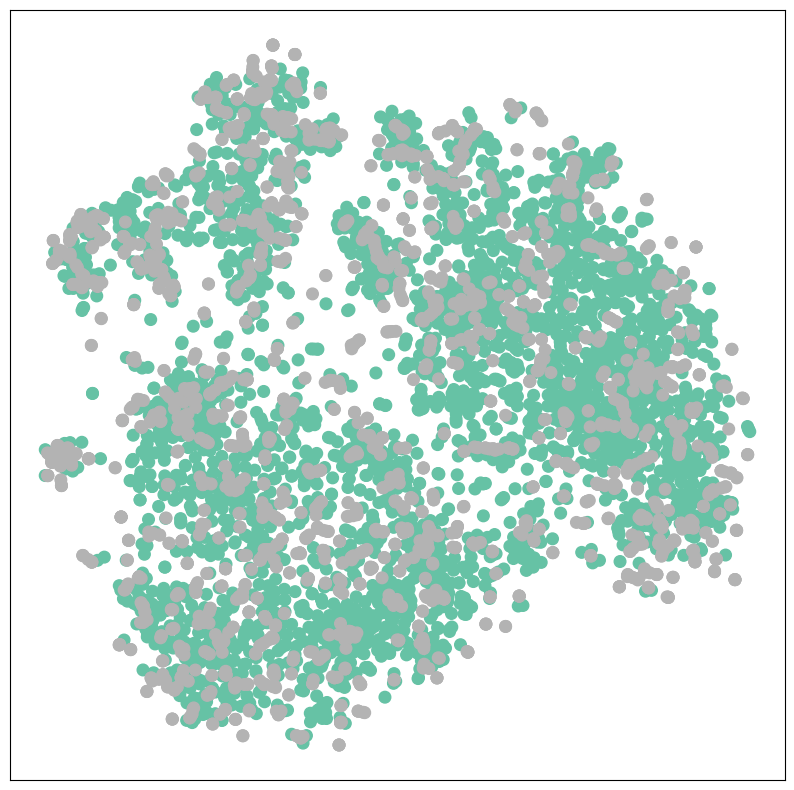

In [19]:
# TSNE
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# run the tsne
visualize(data.features, data.VAP.detach().cpu().numpy())